In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import WindowDataset
import CustomModels
import CustomMetrics
import CustomWindowGenerator

%load_ext autoreload
%autoreload 2

# DATASET

## Load Dataset

In [2]:
data_horaria_estandarizada_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Horaria_Estandarizada.xlsx')
data_horaria_estandarizada = pd.read_excel(data_horaria_estandarizada_path)
data_horaria_estandarizada = data_horaria_estandarizada.set_index('Fecha')

In [3]:
precio_bolsa_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Precio_Bolsa_Estandarizada.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

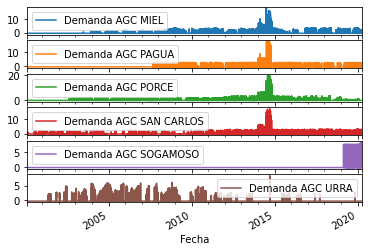

In [4]:
plot_cols = data_horaria_estandarizada.columns[-6:]
plot_features = data_horaria_estandarizada[plot_cols]
_ = plot_features.plot(subplots=True)

In [5]:
full_df = pd.concat([data_horaria_estandarizada,precio_bolsa],axis=1)
full_df.shape,data_horaria_estandarizada.shape,precio_bolsa.shape

((176760, 85), (176760, 84), (176760, 1))

In [6]:
train_df = full_df[(full_df.index >= '2000-01-01') & (full_df.index < '2019-01-01')]
val_df = full_df[(full_df.index >= '2019-01-01') & (full_df.index < '2020-01-01')]
test_df = full_df[full_df.index >= '2019-12-31']

train_df.shape,val_df.shape,test_df.shape

((165816, 85), (8760, 85), (2208, 85))

## Build Window

In [7]:
inputs_columns = ['Generacion ALBAN', 'Generacion BETANIA', 'Generacion CHIVOR',
          'Generacion EL QUIMBO', 'Generacion GUATAPE', 'Generacion GUATRON',
          'Generacion GUAVIO', 'Generacion LA TASAJERA', 'Generacion MIEL',
          'Generacion PAGUA', 'Generacion PLAYAS', 'Generacion PORCE',
          'Generacion SAN CARLOS', 'Generacion SOGAMOSO', 'Generacion URRA','$kWh']
#output_columns = inputs_columns

#inputs_columns = ['$kWh']
output_columns = ['$kWh']

In [8]:
window_train = CustomWindowGenerator.MyWindowDatasetGenerator(data=train_df, times=24, shift=24,
                                                              input_signals=inputs_columns, output_signals=output_columns)

train_generator = window_train.make_dataset(train_df,batch_size=16,suffle=True,sequence_stride=24)

In [9]:
window_val = CustomWindowGenerator.MyWindowDatasetGenerator(data=val_df, times=24, shift=24,
                                                            input_signals=inputs_columns, output_signals=output_columns)

val_generator = window_val.make_dataset(val_df,batch_size=16,suffle=True,sequence_stride=24)

In [10]:
window_test = CustomWindowGenerator.MyWindowDatasetGenerator(data=test_df, times=24, shift=24,
                                                             input_signals=inputs_columns, output_signals=output_columns)

test_generator = window_test.make_dataset(test_df,batch_size=16,suffle=False,sequence_stride=24)

# MODELS

## Instantiate Models

In [11]:
custom_rnn  = CustomModels.CustomRNN(rnn_units=15,output_units=24)
custom_lstm = CustomModels.CustomLSTM(lstm_units=15,output_units=24)
custom_gru  = CustomModels.CustomGRU(gru_units=15,output_units=24)
custom_cnn  = CustomModels.CustomCNN(dropout_rate=0.31,output_units=24)

## Instantiate metrics dicts

In [12]:
val_performance = dict()
performance = dict()

## Compile & Fit Method

In [13]:
def compile_and_fit(model, window_train, window_val, epochs, steps_per_epoch, val_steps,patience):
    """
    Este método se encarga de definir las funciones Callback, compilar y además realizar entrenar
    el modelo. Entre las funciones Callback que se definen aquí están: Logs de TensorBoard, Redu-
    cción del Learning Rate cuando la métrica se queda estancada y Frenado del proceso de  entre-
    namient.
    Input:
        - model: Estimador que se va a entrenar.
        - window_train: Generador de datos con el cual se va a entrenar.
        - window_val: Generador de datos con el cual se va a evaluar.
        - epochs: Entero con las épocas de entrenamiento.
        - steps_per_epoch: Entero con la cantidad de pasos por época.
        - val_steps: Entero con los pasos por época para evaluación.
        - patience: Entero que determina cuantas epocas pasaran antes de ejecutar una acción del
        callback.
    Output:
        - history: Diccionario con los resultados del entrenamiento del modelo.
    """
    log_dir = os.path.join('logs',model.name)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=2,
                                                          write_graph=False,
                                                          update_freq='epoch')
    
    callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                              factor=0.1,
                                                              min_lr=1e-4,
                                                              patience=0,
                                                              verbose=1)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    
    callbacks = [callback_tensorboard,callback_reduce_lr,early_stopping]
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanAbsolutePercentageError(),
                           CustomMetrics.symmetric_mean_absolute_percentage_error])
    
    history = model.fit(x=window_train,epochs=epochs,steps_per_epoch=steps_per_epoch,
              validation_data=window_val,validation_steps=val_steps,callbacks=callbacks)
    
    return history

## Predictions & Plot

In [14]:
def generate_predictions_style_1(inputs,labels,model):
    
    batch_predictions = model.predict(inputs)
    
    return batch_predictions

In [15]:
def plot_comparison(inputs,predictions):
    
    flat_signal_true = tf.reshape(inputs, [-1,1])
    flat_signal_pred = tf.reshape(predictions, [-1,1])

    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(flat_signal_true, label='true')
    plt.plot(flat_signal_pred, label='pred')

    plt.ylabel('Precio en Bolsa Nacional')
    plt.legend()
    plt.show()

## Execute experiments

### Recurrent Neuronal Network

In [16]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomRNN(rnn_units=83,output_units=24)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_rnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 83)                8300      
_________________________________________________________________
dense (Dense)                (None, 24)                2016      
Total params: 10,316
Trainable params: 10,316
Non-trainable params: 0
_________________________________________________________________


In [17]:
history = compile_and_fit(model=custom_rnn, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
  1/300 [..............................] - ETA: 0s - loss: 3.7455 - mean_absolute_error: 1.1526 - mean_absolute_percentage_error: 440.7401 - symmetric_mean_absolute_percentage_error: 3498.0769WARNING:tensorflow:From C:\Users\SEBASTIAN\anaconda3\envs\proyecto-grados\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
300/300 [==============================] - 7s 23ms/step - loss: 0.8199 - mean_absolute_error: 0.4845 - mean_absolute_percentage_error: 385.2212 - symmetric_mean_absolute_percentage_error: 2492.6660 - val_loss: 0.2565 - val_mean_absolute_error: 0.3934 - val_mean_absolute_percentage_error: 757.7921 - val_symmetric_mean_absolute_percentage_error: 1900.4391
Epoch 2/100
132/300 [============>.................] - 3s 20ms/step - loss: 0.3641 - mean_absolute_error: 0.2943 - mean_absolute_perc

In [18]:
val_performance['DNN'] = custom_rnn.evaluate(val_generator)
performance['RNN'] = custom_rnn.evaluate(test_generator)

6/6 [==============================] - 0s 4ms/step - loss: 0.3319 - mean_absolute_error: 0.4460 - mean_absolute_percentage_error: 74.6068 - symmetric_mean_absolute_percentage_error: 792.5473


In [19]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

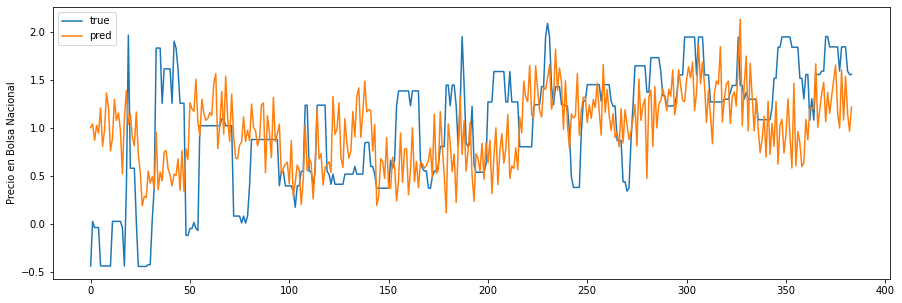

In [20]:
predictions = generate_predictions_style_1(inputs,labels,custom_rnn)
plot_comparison(labels,predictions)

### Long Short Term Memory

In [21]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomLSTM(lstm_units=83,output_units=24)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_lstm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 83)                33200     
_________________________________________________________________
dense_1 (Dense)              (None, 24)                2016      
Total params: 35,216
Trainable params: 35,216
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = compile_and_fit(model=custom_lstm, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 4s 14ms/step - loss: 0.6877 - mean_absolute_error: 0.3977 - mean_absolute_percentage_error: 237.3459 - symmetric_mean_absolute_percentage_error: 2423.5918 - val_loss: 0.2385 - val_mean_absolute_error: 0.3672 - val_mean_absolute_percentage_error: 549.6934 - val_symmetric_mean_absolute_percentage_error: 1995.1237
Epoch 2/100
132/300 [============>.................] - 1s 6ms/step - loss: 0.2472 - mean_absolute_error: 0.2185 - mean_absolute_percentage_error: 229.4899 - symmetric_mean_absolute_percentage_error: 1456.1500


In [23]:
val_performance['LSTM'] = custom_lstm.evaluate(val_generator)
performance['LSTM'] = custom_lstm.evaluate(test_generator)

6/6 [==============================] - 0s 4ms/step - loss: 0.2646 - mean_absolute_error: 0.4051 - mean_absolute_percentage_error: 69.9442 - symmetric_mean_absolute_percentage_error: 783.2930


In [24]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

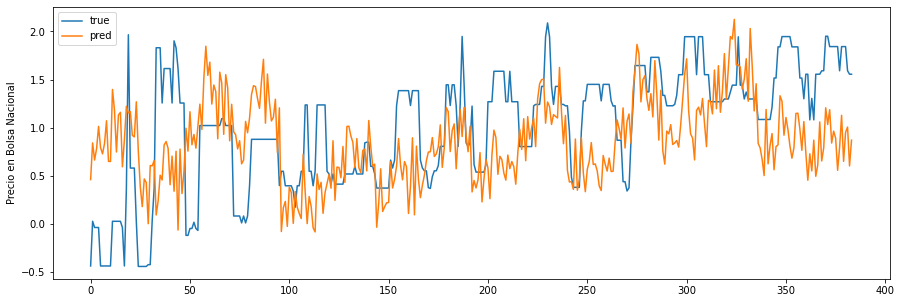

In [25]:
predictions = generate_predictions_style_1(inputs,labels,custom_lstm)
plot_comparison(labels,predictions)

### Gated Recurrent Unit

In [26]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomGRU(gru_units=83,output_units=24)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_gru_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 83)                25149     
_________________________________________________________________
dense_2 (Dense)              (None, 24)                2016      
Total params: 27,165
Trainable params: 27,165
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = compile_and_fit(model=custom_gru, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 22s 72ms/step - loss: 0.7179 - mean_absolute_error: 0.4193 - mean_absolute_percentage_error: 272.5746 - symmetric_mean_absolute_percentage_error: 2396.6499 - val_loss: 0.1673 - val_mean_absolute_error: 0.3099 - val_mean_absolute_percentage_error: 451.3793 - val_symmetric_mean_absolute_percentage_error: 1689.2578
Epoch 2/100
132/300 [============>.................] - 8s 63ms/step - loss: 0.2727 - mean_absolute_error: 0.2121 - mean_absolute_percentage_error: 187.4516 - symmetric_mean_absolute_percentage_error: 1284.3435


In [28]:
val_performance['GRU'] = custom_gru.evaluate(val_generator)
performance['GRU'] = custom_gru.evaluate(test_generator)

6/6 [==============================] - 0s 6ms/step - loss: 0.2360 - mean_absolute_error: 0.3737 - mean_absolute_percentage_error: 83.9076 - symmetric_mean_absolute_percentage_error: 675.2391


In [29]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

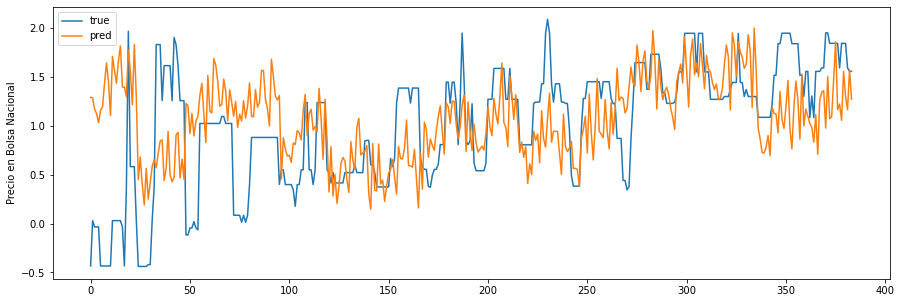

In [30]:
predictions = generate_predictions_style_1(inputs,labels,custom_gru)
plot_comparison(labels,predictions)

### Convolutional Neuronal Network

In [31]:
inputs = tf.keras.layers.Input(shape=(24,85))
custom_model = CustomModels.CustomCNN(dropout_rate=83,output_units=24)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 64)            10944     
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 23, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 24)               

In [32]:
history = compile_and_fit(model=custom_cnn, window_train=train_generator,
                          window_val=val_generator,epochs=100,
                          steps_per_epoch=300,val_steps=300,patience=5)

Epoch 1/100
300/300 [==============================] - 3s 11ms/step - loss: 0.7484 - mean_absolute_error: 0.5671 - mean_absolute_percentage_error: 590.3202 - symmetric_mean_absolute_percentage_error: 2798.8035 - val_loss: 0.2249 - val_mean_absolute_error: 0.3664 - val_mean_absolute_percentage_error: 600.6418 - val_symmetric_mean_absolute_percentage_error: 2014.5487
Epoch 2/100
132/300 [============>.................] - 1s 6ms/step - loss: 0.3430 - mean_absolute_error: 0.3945 - mean_absolute_percentage_error: 501.2032 - symmetric_mean_absolute_percentage_error: 2259.1523


In [33]:
val_performance['CNN'] = custom_cnn.evaluate(val_generator)
performance['CNN'] = custom_cnn.evaluate(test_generator)

6/6 [==============================] - 0s 7ms/step - loss: 0.3343 - mean_absolute_error: 0.4681 - mean_absolute_percentage_error: 59.8747 - symmetric_mean_absolute_percentage_error: 905.4221


In [34]:
inputs, labels = next(iter(test_generator))

**Estilo 1:** Usando todos los valores de Test.

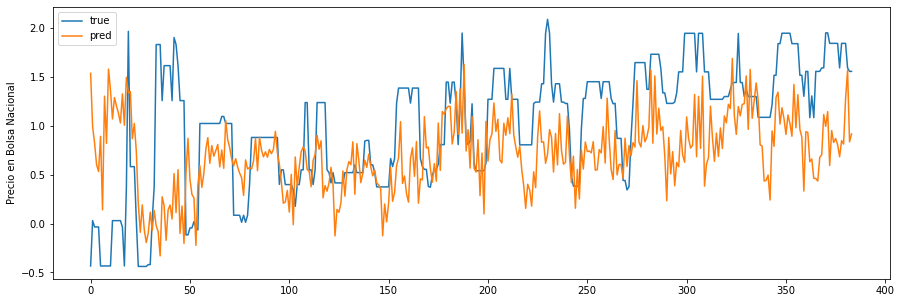

In [35]:
predictions = generate_predictions_style_1(inputs,labels,custom_cnn)
plot_comparison(labels,predictions)

## Metrics Summary

In [36]:
pd.DataFrame(val_performance,index=['Loss','Mean Absolute Error',
                                    'Mean Absolute Percentage Error',
                                    'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.179197,0.325293,590.175293,1680.283569
LSTM,0.178371,0.315115,535.755005,1739.203247
GRU,0.129956,0.270774,341.782593,1500.864624
CNN,0.176281,0.319170,470.422577,1809.590820


In [37]:
pd.DataFrame(performance,index=['Loss','Mean Absolute Error',
                                'Mean Absolute Percentage Error',
                                'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
RNN,0.331946,0.446046,74.606796,792.547302
LSTM,0.264579,0.405073,69.944206,783.293030
GRU,0.235956,0.373708,83.907623,675.239075
CNN,0.334345,0.468093,59.874657,905.422119
